# Preprocessing of Calcium signals

In [1]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('..')
from physion.dataviz.show_data import MultimodalData

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Loading a datafile with Calcium Imaging data

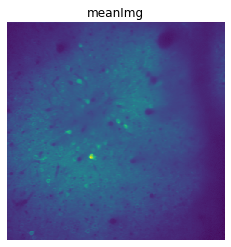

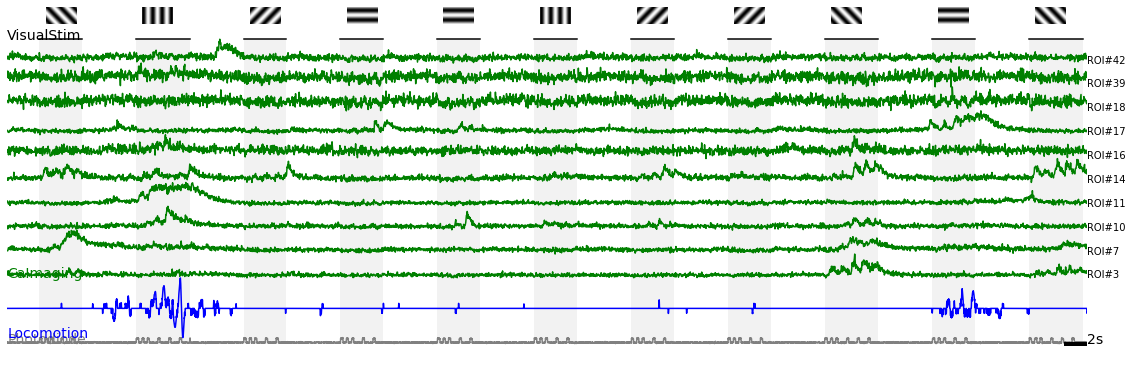

In [10]:
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'Wild_Type', '2021_03_11-17-13-03.nwb')
data = MultimodalData(filename)
_ = data.show_CaImaging_FOV(key='meanImg', NL=2)
_ = data.plot([250.3, 351], 
              settings={'Photodiode':dict(fig_fraction=.1, subsampling=10, color='grey'),
                        'Locomotion':dict(fig_fraction=1, subsampling=10, color='b'),
                        'CaImaging':dict(fig_fraction=4, 
                                         quantity='CaImaging', subquantity='Fluorescence', color='green',
                                                   roiIndices=[2, 6, 9, 10, 13, 15, 16, 17, 38, 41]),
                        'VisualStim':dict(fig_fraction=0, size=0.04, color='black')},                    
              Tbar=2)

## Looking at the raw ROI fluorescence and neuropil signals

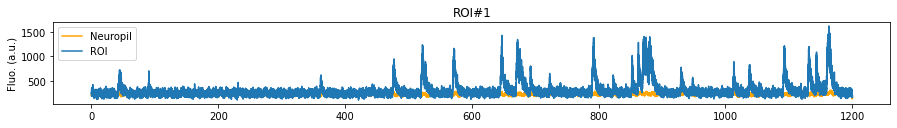

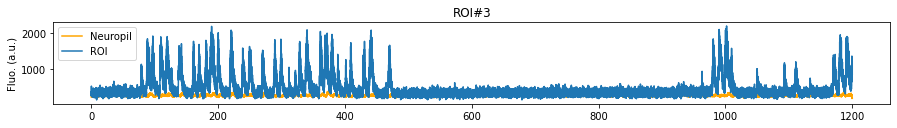

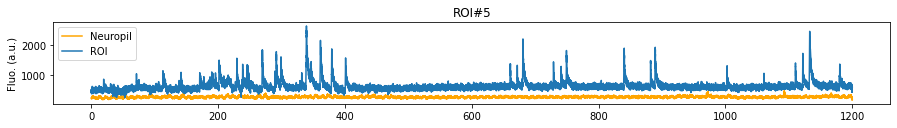

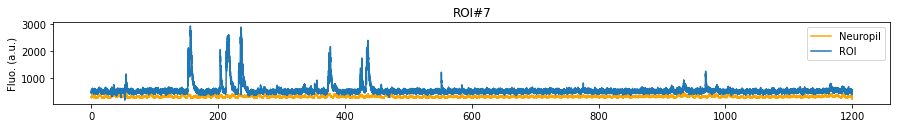

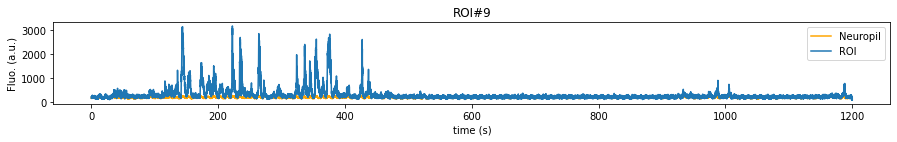

In [3]:
data = Data(filename)

for ROI in range(10)[::2]:
    fig, ax = plt.subplots(figsize=(15,1.5))
    plt.plot(data.Fluorescence.timestamps[:], data.Neuropil.data[ROI,:], label='Neuropil', color='orange')
    plt.plot(data.Fluorescence.timestamps[:], data.Fluorescence.data[ROI,:], label='ROI')
    plt.title('ROI#%i' % (ROI+1))
    plt.legend()
    plt.ylabel('Fluo. (a.u.)')
plt.xlabel('time (s)');

## Computing the $\Delta$F/F

- we evaluate the baseline signal with a sliding percentile, that we smooth

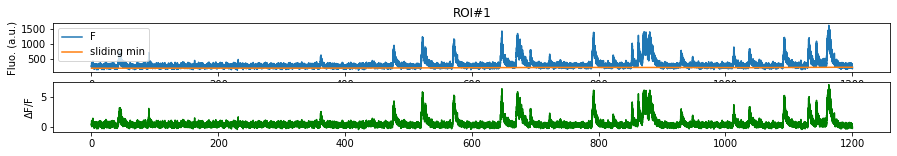

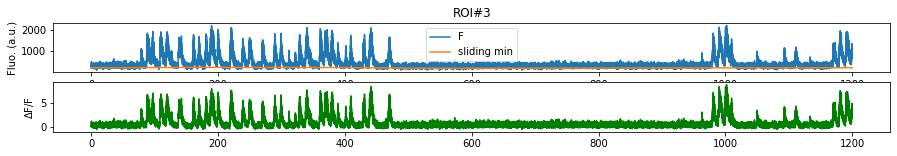

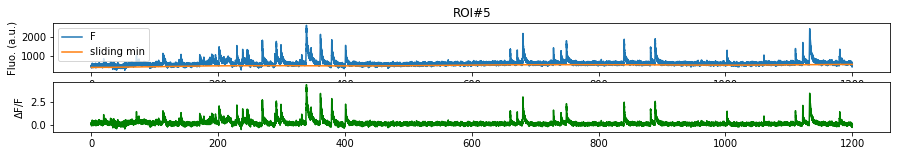

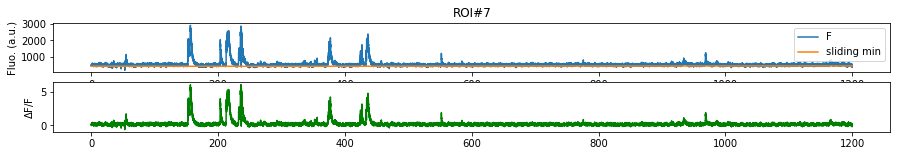

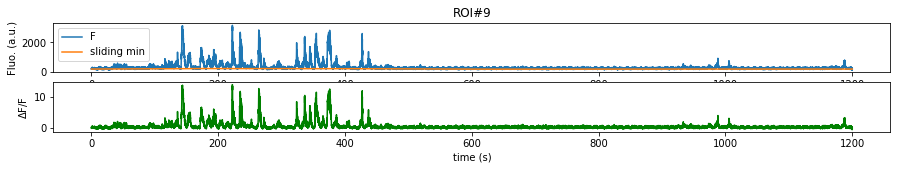

In [9]:
from scipy.ndimage import filters
from physion.Ca_imaging.tools import sliding_percentile 

data = Data(filename)

sliding_window = int(60./data.CaImaging_dt) # 1 min sliding window
percentile = 5 # 5th percentile
for ROI in range(10)[::2]:
    fig, [ax,ax2] = plt.subplots(2,figsize=(15,2))
    F = data.Fluorescence.data[data.validROI,:]
    Fmin = sliding_percentile(F, percentile, sliding_window) # sliding percentile
    Fmin = filters.gaussian_filter1d(Fmin, sliding_window) # + smoothing
    DFoF = (data.Fluorescence.data[ROI,:]-Fmin)/Fmin
    ax.plot(data.Fluorescence.timestamps[:], data.Fluorescence.data[ROI,:], label='F')
    ax2.plot(data.Fluorescence.timestamps[:], DFoF, color='g')
    ax.plot(data.Fluorescence.timestamps[:], Fmin, label='sliding min')
    ax.set_title('ROI#%i' % (ROI+1))
    ax.legend()
    ax.set_ylabel('Fluo. (a.u.)')
    ax2.set_ylabel('$\Delta$F/F')
plt.xlabel('time (s)');

## Deconvolution

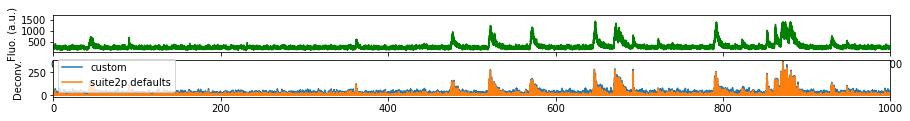

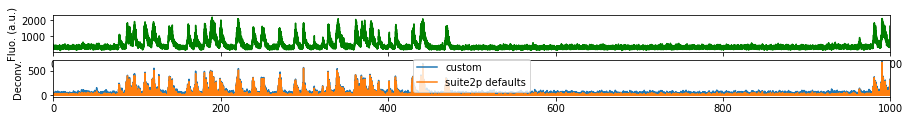

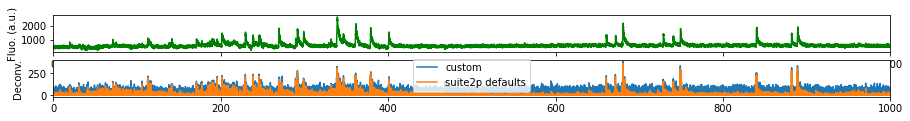

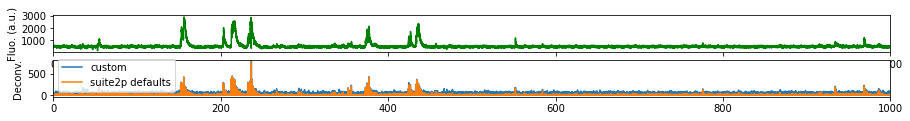

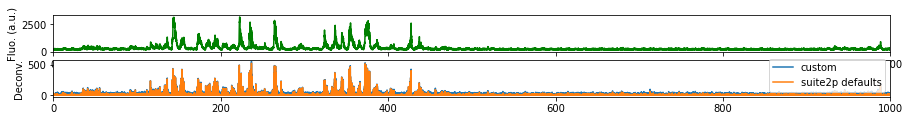

In [7]:
from suite2p.extraction.dcnv import oasis # NEED THE DECONVOLUTION CODE FROM SUITE2P
Tau = 0.7
Dcnv = oasis(data.Fluorescence.data[:]-0.7*data.Neuropil.data[:], 5000, 1./data.CaImaging_dt, Tau)
ROI =1
for ROI in range(10)[::2]:
    fig, [ax,ax2] = plt.subplots(2, figsize=(15,1.5))
    ax.plot(data.Fluorescence.timestamps[:], data.Fluorescence.data[ROI,:], color='green')
    ax2.plot(data.Fluorescence.timestamps[:], Dcnv[ROI,:], label='custom')
    ax2.plot(data.Fluorescence.timestamps[:], data.Deconvolved.data[ROI,:], label='suite2p defaults')
    ax.set_ylabel('Fluo. (a.u.)')
    ax2.set_ylabel('Deconv.')
    for a in [ax, ax2]:
        a.set_xlim([0,1000])
    ax2.legend()